In [1]:
%run "part01_preprocessing.ipynb"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
 8   Unnamed: 8   0 non-null       float64
dtypes: float64(3), int64(1), object(5)
memory usage: 37.2+ MB


In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image


In [3]:
#retornar o a a porcentagem e o valor da porcentagem e forma de texto
def func(pct, allvalues): 
    absolute = int(pct / 100.*np.sum(allvalues)) 
    return "{:.2f}%\n\n{:d}".format(pct, absolute) 

In [4]:
def display_stats(df):
    
    """
    Function to display descriptive statistics of numerical variables, includes skewness & kurtosis.   
    """
    
    df=data.describe()
    skewness=data.skew()
    kurtosis=data.kurtosis()
    df=df.append([skewness, kurtosis],ignore_index=True)
    idx=pd.Series(['count','mean','std','min','25%','50%','75%','max','skewness','kurtosis'],name='Summary Statistic')
    df=pd.concat([df,idx],1).set_index('Summary Statistic')
    df=df.drop('count',axis=0)    
    
    cm = sns.light_palette("#A2A2A2", as_cmap = True)
    display(df.style.format('{:.2f}').background_gradient(subset=(df.index[1:],df.columns[:]),cmap=cm)\
            .highlight_min(axis = 0, color = "#FF6347")\
            .highlight_max(axis = 0, color = "#2F4F4F"))
   
display_stats(data)

,Quantity,UnitPrice,CustomerID,Total,year,month,week_of_year,day
Summary Statistic,,,,,,,,
mean,12.05,3.46,15287.80,20.41,2016.93,7.54,30.77,15.00
std,43.79,69.32,1713.58,118.41,0.25,3.41,14.76,8.80
min,-3114.00,0.04,12347.00,-38970.00,2016.00,1.00,1.00,1.00
25%,2.00,1.25,13954.00,4.20,2017.00,5.00,19.00,7.00
50%,5.00,1.95,15152.00,11.10,2017.00,8.00,34.00,15.00
75%,12.00,3.75,16791.00,19.50,2017.00,11.00,44.00,22.00
max,4800.00,38970.00,18287.00,38970.00,2017.00,12.00,51.00,31.00
skewness,25.58,452.19,0.03,3.54,-3.50,-0.45,-0.46,0.12
kurtosis,1683.31,246891.91,-1.18,58141.86,10.22,-1.07,-1.10,-1.19


In [5]:
data_eda=data.copy()

In [6]:
purchase = data_eda[data_eda['Quantity'] >= 0]
returns = data_eda[data_eda['Quantity'] < 0]

In [7]:
purchase

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,year,month,week_of_year,day
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom,15.30,2016,11,48,29
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom,20.34,2016,11,48,29
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom,22.00,2016,11,48,29
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom,20.34,2016,11,48,29
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom,20.34,2016,11,48,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2017-12-07,0.85,12680,France,10.20,2017,12,49,7
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2017-12-07,2.10,12680,France,12.60,2017,12,49,7
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2017-12-07,4.15,12680,France,16.60,2017,12,49,7
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2017-12-07,4.15,12680,France,16.60,2017,12,49,7


In [8]:
sales=purchase[['CustomerID','Total','InvoiceNo','InvoiceDate']].groupby('InvoiceNo').agg({'Total':np.sum,
                                                                 'CustomerID':np.unique,
                                                                 'InvoiceDate':np.unique})

In [9]:
sales

,Total,CustomerID,InvoiceDate
InvoiceNo,,,
536365,139.12,17850,2016-11-29
536366,22.20,17850,2016-11-29
536367,278.73,13047,2016-11-29
536368,70.05,13047,2016-11-29
536369,17.85,13047,2016-11-29
...,...,...,...
581583,124.60,13777,2017-12-07
581584,140.64,13777,2017-12-07
581585,329.05,15804,2017-12-07


In [10]:
sales_per_customer=sales.groupby('CustomerID').mean()
sales_per_customer

,Total
CustomerID,
12347,615.714286
12348,449.310000
12349,1757.550000
12350,334.400000
12352,313.255000
...,...
18280,180.600000
18281,80.820000
18282,89.025000


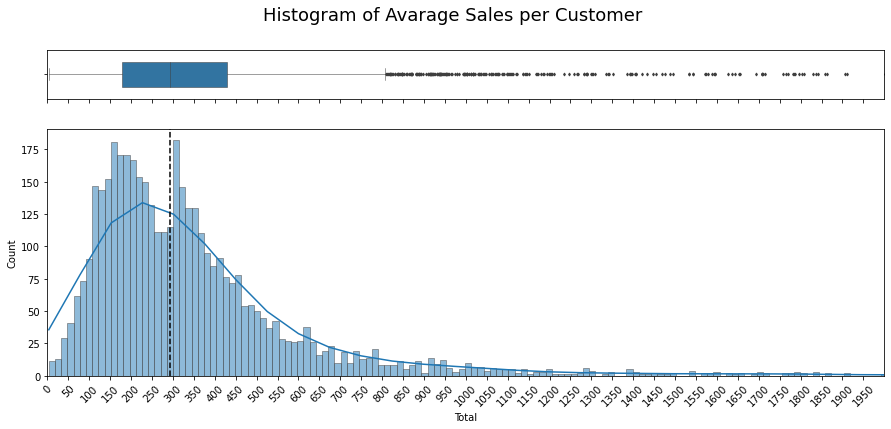

In [11]:
fig, (ax_box, ax_hist) = plt.subplots(2, figsize=(15,6), sharex=True, gridspec_kw = {"height_ratios": (0.2, 1)})
fig.suptitle('Histogram of Avarage Sales per Customer', fontsize=18)
sns.boxplot(x=sales_per_customer['Total'], ax=ax_box, linewidth=.5, width=.5, fliersize=2)
ax_box.set(xlabel='')
sns.histplot(data=sales_per_customer['Total'], ax=ax_hist, bins=1000, kde=True, edgecolor=".3", linewidth=.5 )
ax_hist.axvline(sales_per_customer['Total'].median(), color='black', ls='--')
plt.xticks(np.arange(0,2000,50), rotation=45)
plt.xlim([0,2000])
plt.savefig("..//images//histogram_avarage_sales.png")
plt.show()

In [12]:
zipsorted = sales_per_customer.sort_values(by='Total',ascending=False)
zipsorted['Rank'] = np.divmod(np.arange(len(zipsorted)), 1)[0]+1
zipsorted['Total'] = zipsorted['Total'].round(2)
#di.export(zipsorted,'../images/df_rank_sales.png', max_rows=10)

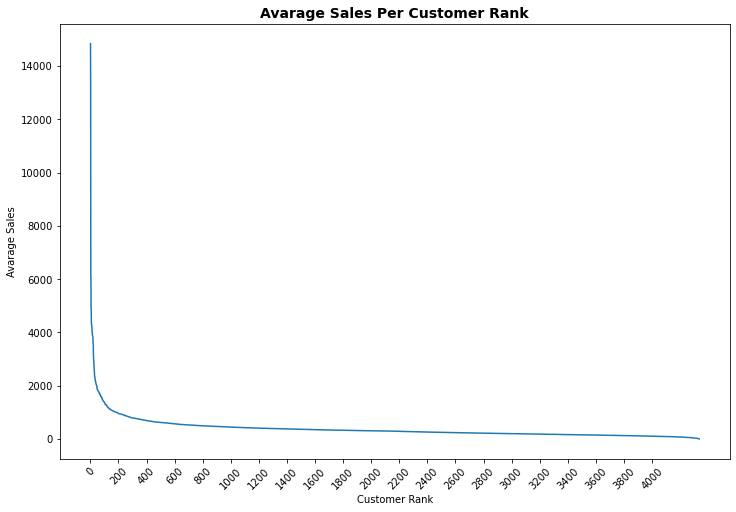

In [13]:
plt.figure(figsize=(12,8))
plt.title('Avarage Sales Per Customer Rank', fontsize=14, fontweight='bold')
sns.lineplot(x='Rank', y='Total', data=zipsorted) 
plt.xlabel('Customer Rank')
plt.ylabel('Avarage Sales') 
plt.xticks(np.arange(0,4200,200), rotation=45)
plt.savefig("..//images//sales_rank.png")
plt.show()

In [14]:
# sum all values of a list and return the percentage and sum
def func(pct, allvalues): 
    absolute = int(pct / 100.*np.sum(allvalues)) 
    return "{:.2f}%\n\n{:d}".format(pct, absolute) 

In [15]:
country_1=data_eda['Country'].value_counts().iloc[:1]
country_o=data_eda['Country'].value_counts().iloc[1:].sum()

others=pd.Series( data=country_o, index=["Others"], name ="Country") 
country_resume = pd.concat([country_1, others])

In [16]:
print("Total of Countries:", data_eda['Country'].nunique()-1)

Total of Countries: 36


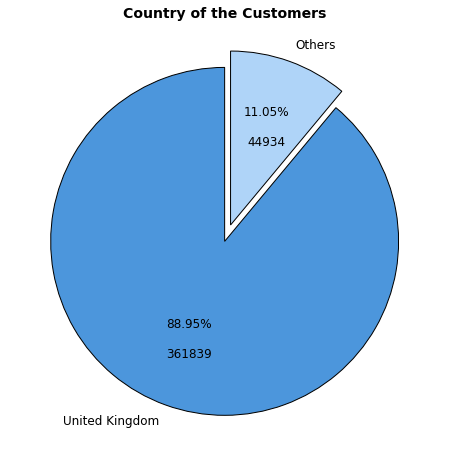

In [17]:
plt.figure(figsize=(12,8))
plt.title('Country of the Customers', fontsize=14, fontweight='bold')

labels = country_resume.index.tolist()
sizes = country_resume.tolist()

plt.pie(sizes, 
        labels=labels, 
        colors=['#4C96DC','#AFD4F8'],
        explode = (0, 0.1), 
        autopct = lambda pct: func(pct, sizes), 
        startangle=90,
        wedgeprops = { 'linewidth' : 1, 'edgecolor' : "black"}, textprops={'fontsize': 12})


plt.savefig("..//images//sales_country.png")
plt.show()

In [18]:
temporal = data.copy()

In [19]:
temporal=temporal.set_index(temporal['InvoiceDate']).sort_index(ascending=True)


In [20]:
temporal_d = temporal.resample('D').mean()
temporal_m = temporal.resample('M').mean()
temporal_y = temporal.resample('Y').mean()

<AxesSubplot:xlabel='InvoiceDate'>

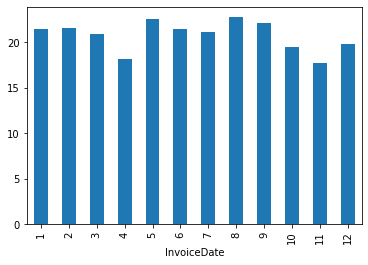

In [21]:
temporal['Total'].groupby(temporal.index.month).mean().plot(kind='bar')

<AxesSubplot:xlabel='day'>

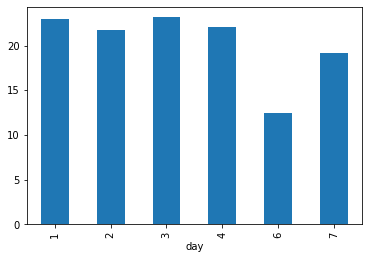

In [22]:
temporal['Total'].groupby(temporal.index.isocalendar().day).mean().plot(kind='bar')

In [23]:
description = data.dropna(subset=['Description'], axis=0)['Description']
description.iloc[220]

'WHITE HANGING HEART T-LIGHT HOLDER'

In [24]:
all_description = " ". join( s for s in description)
print("Total Words: {}".format(len(all_description)))

Total Words: 11253798


In [25]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color='black', width=2400, height=1800).generate(all_description)

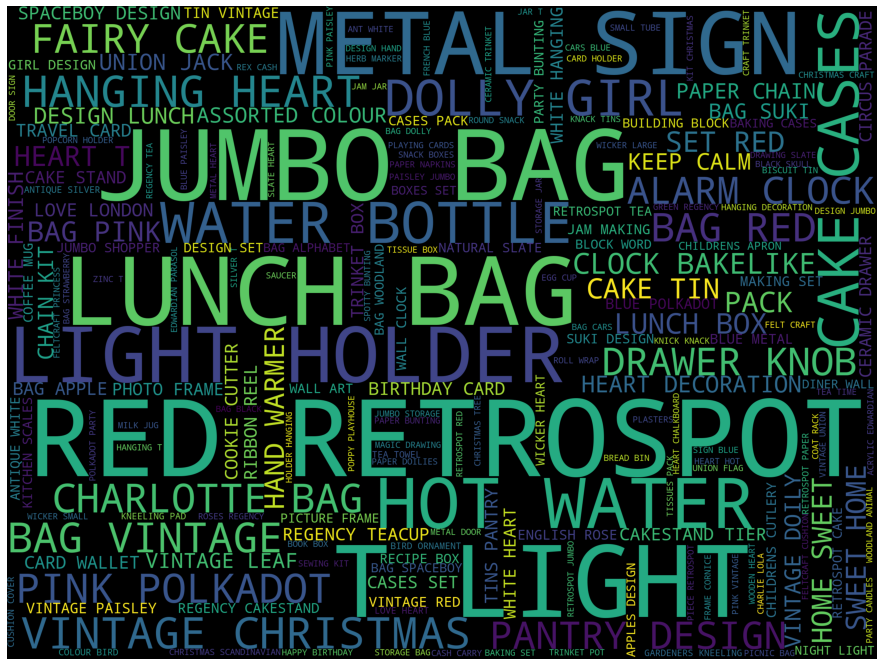

In [26]:
fig,ax = plt.subplots(figsize=(18,12))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud);

In [27]:
data.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,year,month,week_of_year,day
217693,555931,85230A,OPIUM SCENTED VOTIVE CANDLE,24,2017-06-06,0.29,17828,Malta,6.96,2017,6,23,6
459947,575886,22063,CERAMIC BOWL WITH STRAWBERRY DESIGN,2,2017-11-09,2.95,12517,Germany,5.90,2017,11,45,9
328921,565839,23035,DRAWER KNOB CERAMIC IVORY,6,2017-09-05,1.45,13186,United Kingdom,8.70,2017,9,36,5
250138,559004,21094,SET/6 RED SPOTTY PAPER PLATES,12,2017-07-03,0.85,12428,Finland,10.20,2017,7,27,3
335549,566290,22745,POPPY'S PLAYHOUSE BEDROOM,1,2017-09-09,2.10,14456,United Kingdom,2.10,2017,9,36,9


In [28]:
import regex

In [29]:
df_letter_invoices = data[data['InvoiceNo'].apply(lambda x: bool(regex.search('[^0-9]+',x)))]

print('Total number of invoices with letters: {}.'.format(len(df_letter_invoices)))
print('Total number of negative quantity in invoices with letters: {}.'.format(len(df_letter_invoices[df_letter_invoices['Quantity'] < 0])))

Total number of invoices with letters: 8899.
Total number of negative quantity in invoices with letters: 8899.


In [30]:
df_letter_stock = data[data['StockCode'].apply(lambda x: bool(regex.search('[^0-9]+',x)))]

In [31]:
df_letter_stock.sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,year,month,week_of_year,day
93503,544295,85230B,CINNAMON SCENTED VOTIVE CANDLE,48,2017-02-15,0.21,14298,United Kingdom,10.08,2017,2,7,15
168524,551057,85099C,JUMBO BAG BAROQUE BLACK WHITE,2,2017-04-24,2.08,16942,United Kingdom,4.16,2017,4,17,24
101123,544900,84970L,SINGLE HEART ZINC T-LIGHT HOLDER,12,2017-02-22,0.95,15121,United Kingdom,11.40,2017,2,8,22
155104,549966,35810A,ENAMEL PINK COFFEE CONTAINER,12,2017-04-11,0.83,16224,United Kingdom,9.96,2017,4,15,11
304288,563567,85099F,JUMBO BAG STRAWBERRY,10,2017-08-15,2.08,13004,United Kingdom,20.80,2017,8,33,15
129143,547377,85194S,HANGING SPRING FLOWER EGG SMALL,24,2017-03-20,0.65,13050,United Kingdom,15.60,2017,3,12,20
171011,551351,82001S,VINYL RECORD FRAME SILVER,24,2017-04-26,3.39,14298,United Kingdom,81.36,2017,4,17,26
309535,564093,85099B,JUMBO BAG RED RETROSPOT,10,2017-08-21,2.08,14930,Channel Islands,20.80,2017,8,34,21
111520,C545740,POST,POSTAGE,-1,2017-03-05,8.65,18257,United Kingdom,-8.65,2017,3,9,5
70513,542080,84997D,PINK 3 PIECE POLKADOT CUTLERY SET,6,2017-01-23,3.75,13815,Germany,22.50,2017,1,4,23


In [32]:
print('Total number of StockCode with letters: {}.'.format(len(df_letter_stock)))
print('Total number of negative quantity in StockCode with letters: {}.'.format(len(df_letter_stock[df_letter_stock['Quantity'] < 0])))

Total number of StockCode with letters: 35794.
Total number of negative quantity in StockCode with letters: 1001.


In [33]:
df_letter_invoices.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,year,month,week_of_year,day
527381,C580714,22720,SET OF 3 CAKE TINS PANTRY DESIGN,-2,2017-12-03,4.95,12479,Germany,-9.90,2017,12,48,3
42557,C540006,21306,SET/4 DAISY MIRROR MAGNETS,-1,2017-01-02,2.10,14606,United Kingdom,-2.10,2017,1,1,2
268339,C560409,15036,ASSORTED COLOURS SILK FAN,-24,2017-07-16,0.83,16717,United Kingdom,-19.92,2017,7,28,16
394044,C570867,22050,PINK PAISLEY ROSE GIFT WRAP,-25,2017-10-10,0.42,12607,USA,-10.50,2017,10,41,10
122409,C546870,M,Manual,-2,2017-03-15,2.50,14462,United Kingdom,-5.00,2017,3,11,15


In [34]:
list_special_codes = data[data['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'DOT', 'CRUK'],
      dtype=object)

In [35]:
# list_special_codes = data[data['InvoiceNo'].str.contains('^[a-zA-Z]+', regex=True)]['InvoiceNo'].unique()
# list_special_codes

In [36]:
# df_letter_invoices["IsCancelled"]=np.where(df_letter_invoices.InvoiceNo.apply(lambda l: l[0]=="C"), True, False)
# df_letter_invoices.IsCancelled.value_counts() / df_letter_invoices.shape[0] * 100

In [37]:
#trash = data[data['StockCode'].apply(lambda x: bool(regex.search('^[a-zA-Z]+$',x)))]['StockCode']#.unique()

In [38]:
data.loc[(data['CustomerID'] == 14096)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,year,month,week_of_year,day
317502,564764,16207B,PINK HEART RED HANDBAG,1,2017-08-28,2.46,14096,United Kingdom,2.46,2017,8,35,28
317503,564764,16225,RATTLE SNAKE EGGS,1,2017-08-28,3.29,14096,United Kingdom,3.29,2017,8,35,28
317504,564764,16254,TRANSPARENT ACRYLIC TAPE DISPENSER,1,2017-08-28,1.63,14096,United Kingdom,1.63,2017,8,35,28
317505,564764,84249A,"GREETING CARD,SQUARE, DOUGHNUTS",1,2017-08-28,0.83,14096,United Kingdom,0.83,2017,8,35,28
317506,564764,84659A,WHITE TRAVEL ALARM CLOCK,2,2017-08-28,1.23,14096,United Kingdom,2.46,2017,8,35,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
528083,580727,10135,COLOURING PENCILS BROWN TUBE,8,2017-12-03,2.46,14096,United Kingdom,19.68,2017,12,48,3
528084,580727,11001,ASSTD DESIGN RACING CAR PEN,3,2017-12-03,3.29,14096,United Kingdom,9.87,2017,12,48,3
528085,580727,15044A,PINK PAPER PARASOL,1,2017-12-03,5.79,14096,United Kingdom,5.79,2017,12,48,3
528086,580727,15056BL,EDWARDIAN PARASOL BLACK,1,2017-12-03,12.46,14096,United Kingdom,12.46,2017,12,48,3


In [39]:
data_canceled=data.loc[(data['Quantity'] < 0)]
data_canceled

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,year,month,week_of_year,day
141,C536379,D,Discount,-1,2016-11-29,27.50,14527,United Kingdom,-27.50,2016,11,48,29
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,15311,United Kingdom,-4.65,2016,11,48,29
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,17548,United Kingdom,-19.80,2016,11,48,29
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom,-6.96,2016,11,48,29
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom,-6.96,2016,11,48,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2017-12-07,0.83,14397,United Kingdom,-9.13,2017,12,49,7
541541,C581499,M,Manual,-1,2017-12-07,224.69,15498,United Kingdom,-224.69,2017,12,49,7
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2017-12-07,10.95,15311,United Kingdom,-54.75,2017,12,49,7
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2017-12-07,1.25,17315,United Kingdom,-1.25,2017,12,49,7


In [40]:
#C536391

data.loc[(data['CustomerID'] == 17548)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,year,month,week_of_year,day
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,17548,United Kingdom,-19.80,2016,11,48,29
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom,-6.96,2016,11,48,29
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom,-6.96,2016,11,48,29
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2016-11-29,0.29,17548,United Kingdom,-6.96,2016,11,48,29
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2016-11-29,3.45,17548,United Kingdom,-41.40,2016,11,48,29
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2016-11-29,1.65,17548,United Kingdom,-19.80,2016,11,48,29
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2016-11-29,1.65,17548,United Kingdom,-39.60,2016,11,48,29
165024,550755,22585,PACK OF 6 BIRDY GIFT TAGS,24,2017-04-18,1.25,17548,United Kingdom,30.00,2017,4,16,18
165025,550755,22082,RIBBON REEL STRIPES DESIGN,10,2017-04-18,1.65,17548,United Kingdom,16.50,2017,4,16,18
165026,550755,22081,RIBBON REEL FLORA + FAUNA,10,2017-04-18,1.65,17548,United Kingdom,16.50,2017,4,16,18
